#DEEP LEARNING FOR NLP

In this case study, we are employing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers to perform sentiment analysis, classifying text into four distinct categories.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [58]:
df = pd.read_csv("/content/tweets.csv", encoding="latin-1")

In [59]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [60]:
df.shape

(9093, 3)

In [61]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [62]:
df.isna().sum()

,0
tweet_text,1
emotion_in_tweet_is_directed_at,5802
is_there_an_emotion_directed_at_a_brand_or_product,0


In [63]:
#remove rows with value na in tweet text

df = df.dropna(subset=['tweet_text'])

## Cleaning the text

In [64]:
import re

def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
  text = re.sub(r'\@\w+|\#', '', text)  # remove mentions and hashtags
  text = re.sub(r"[^a-z\s]", '', text)  # remove punctuation and digits
  return text.strip()


In [65]:
df['clean_text'] = df['tweet_text'].apply(clean_text)
df[['tweet_text', 'clean_text']].head()

,tweet_text,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,i have a g iphone after hrs tweeting at risea...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipadiphone app that youll...
2,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale t...
3,@sxsw I hope this year's festival isn't as cra...,i hope this years festival isnt as crashy as t...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff on fri sxsw marissa mayer google t...


## Tokenizing the text

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer

#definig the vocab size
vocab_size = 10300

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<DOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])

print("Example tweet:", df['clean_text'].iloc[0])
print("Token sequence:", sequences[0])

Example tweet: i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw
Token sequence: [21, 49, 11, 311, 17, 240, 2122, 651, 6, 3860, 29, 80, 874, 21, 101, 5, 1046, 2473, 3861, 6, 2]


In [67]:
actual_vocab_size = len(tokenizer.word_index) + 1 # +1 for the 0-padding or OOV token if its index is 0
print(f"The actual vocabulary size after tokenizing (before num_words limit for sequences): {actual_vocab_size}")

The actual vocabulary size after tokenizing (before num_words limit for sequences): 10310


## Padding the token sequence

### why padding?
To make all sequences the same length, you add "dummy" values (typically zeros) to the shorter sequences until they match the length of the longest sequence in your batch or a pre-defined max_length.

Example: If your max_length is 20, and you have a tweet that's 15 words long, 5 zeros would be appended (or prepended) to it. A tweet that's 25 words long might be truncated to 20.

Why it's important: It allows for efficient batch processing by the GPU/CPU, as all sequences in a batch can be processed in parallel. Without padding, each sequence would need to be processed individually, which is computationally inefficient.

In [68]:
import numpy as np
tweet_lengths = df['clean_text'].str.len()
percentile_95 = np.percentile(tweet_lengths, 95)
print(f"95th percentile tweet length: {percentile_95:.0f}")

95th percentile tweet length: 130


In [69]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 50
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating = 'post')
print("Shape of padded data:", padded_sequences.shape)
print("Padded example:", padded_sequences[0])

Shape of padded data: (9092, 50)
Padded example: [  21   49   11  311   17  240 2122  651    6 3860   29   80  874   21
  101    5 1046 2473 3861    6    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Label Encoding

In [70]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5388
Positive emotion,2978
Negative emotion,570
I can't tell,156


In [71]:
from sklearn.preprocessing import LabelEncoder

#label encoding target column
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])

print("Label classes:", list(label_encoder.classes_))
print("Example sentiment:", df['is_there_an_emotion_directed_at_a_brand_or_product'].iloc[0], "→", df['label'].iloc[0])

Label classes: ["I can't tell", 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']
Example sentiment: Negative emotion → 1


## Splitting the data

In [72]:
from sklearn.model_selection import train_test_split

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 7273
Testing samples: 1819


## Embedding Matrix using pretrained model

In Natural Language Processing (NLP), **embedding** is the process of converting words, phrases, or even entire documents into numerical vectors. The goal is to represent linguistic items in a continuous vector space where semantically similar items are located closer to each other. This allows machine learning models, which work with numbers, to understand and process text.

Here are different ways to create word embeddings:

* **Frequency-based methods:** These rely on statistical counts of word occurrences.
    * **One-Hot Encoding:** Each word is represented by a vector with a '1' at its unique index and '0's elsewhere. Simple but results in very high-dimensional, sparse vectors that don't capture semantic relationships.
    * **Bag-of-Words (BoW):** Represents a document as a count of its words, disregarding word order.
    * **TF-IDF (Term Frequency-Inverse Document Frequency):** Weighs words based on their frequency in a document and rarity across the entire corpus, giving more importance to distinctive words. These methods are simple but don't capture the semantic relationships between words.

* **Prediction-based methods:** These learn embeddings by training a model to predict words from their context or vice-versa.

    * **Word2Vec:** Developed by Google, Word2Vec is a popular technique that learns word embeddings using shallow neural networks. It has two main architectures:
        * **Continuous Bag-of-Words (CBOW):** Predicts the current word based on its surrounding context words. It's generally faster to train.
        * **Skip-gram:** Predicts the surrounding context words given a target word. It's better at handling rare words and captures semantic relationships more effectively.
        Word2Vec models aim to place words that appear in similar contexts close together in the vector space.

    * **GloVe (Global Vectors for Word Representation):** Developed at Stanford, GloVe combines aspects of both global matrix factorization and local context window methods. It leverages global word-word co-occurrence statistics from the entire corpus to learn word representations. The core idea is that ratios of co-occurrence probabilities can encode meaningful semantic relationships (e.g., the ratio of "ice" to "solid" vs. "steam" to "solid" will be different). GloVe often performs well on tasks involving semantic relationships like word analogies.

* **Contextualized Embeddings:** More recent advancements, like **ELMo** and **BERT**, generate embeddings that are dynamic and depend on the *context* in which a word appears. This addresses the limitation of static embeddings (like Word2Vec and GloVe), where a word like "bank" has only one representation, regardless of whether it refers to a financial institution or a river bank. These models use deep neural networks (often Transformers) to create embeddings that capture nuances of meaning based on the surrounding words in a sentence.

In [73]:
#!pip install gensim

In [74]:
import gensim.downloader as api

embedding_model = api.load("glove-twitter-25")
embedding_dim = 25

In [75]:
embedding_model['great']  # returns a 50-dim vector


array([-8.4229e-01,  3.6512e-01, -3.8841e-01, -4.6118e-01,  2.4301e-01,
        3.2412e-01,  1.9009e+00, -2.2630e-01, -3.1335e-01, -1.0970e+00,
       -4.1494e-03,  6.2074e-01, -5.0964e+00,  6.7418e-01,  5.0080e-01,
       -6.2119e-01,  5.1765e-01, -4.4122e-01, -1.4364e-01,  1.9130e-01,
       -7.4608e-01, -2.5903e-01, -7.8010e-01,  1.1030e-01, -2.7928e-01],
      dtype=float32)

In [76]:
import numpy as np

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill it with GloVe vectors
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        if word in embedding_model:
            embedding_matrix[index] = embedding_model[word]
        else:
            # If word not found in embedding model, leave it as zeros (or use random vector)
            embedding_matrix[index] = np.random.normal(scale=0.1, size=(embedding_dim,))



In [77]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12178113,  0.01527723, -0.00239179, ...,  0.00571131,
        -0.08991935, -0.10918466],
       [-0.34534001,  0.84219998,  0.49182001, ..., -0.17985   ,
        -1.33679998,  0.69471997],
       ...,
       [-1.68159997, -0.56470001,  0.56062001, ..., -0.77179003,
         0.25617   , -0.043498  ],
       [ 0.06899914,  0.00742629,  0.11479086, ..., -0.04500211,
         0.05541694, -0.02279403],
       [-1.3664    , -0.033433  ,  0.63897002, ...,  0.26457   ,
        -0.21832   , -1.23310006]])

In [78]:
print(embedding_matrix[1])

[ 0.12178113  0.01527723 -0.00239179  0.10345359  0.02319882  0.05127755
  0.08851052 -0.02144081 -0.01646742  0.09074668 -0.03320172  0.1045716
 -0.06240529 -0.10999789 -0.05008115  0.02191646 -0.10344891 -0.12507884
 -0.00409924 -0.00523287  0.09806555  0.06041849  0.00571131 -0.08991935
 -0.10918466]


### Building the model



Imagine a pipeline for understanding text. First, the `Embedding` layer takes numerical representations of words and turns them into rich, meaningful vectors, acting like a lookup table for word meanings. This particular embedding layer is `trainable=False`, meaning it uses pre-learned word meanings and won't adjust them during training.

Next, an `LSTM` (Long Short-Term Memory) layer processes these word vectors sequentially. Think of it as a specialized reader that remembers important information from earlier words in the sentence to understand the overall context, even across long distances. It has 64 internal memory units.

Following the LSTM, a `Dense` layer with 32 units acts as a processing step, further refining the information extracted by the LSTM, applying a common 'relu' (rectified linear unit) activation to introduce non-linearity.

Finally, another `Dense` layer acts as the decision-maker. It has 4 units, one for each of your classification categories. The 'softmax' activation function then converts the outputs of these 4 units into probabilities, telling you how likely the input text belongs to each of the four categories.

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Update model with trainable embeddings
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    #input_length=max_length,
    trainable=False
))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile with additional metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │       257,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,500 (1005.86 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 257,500 (1005.86 KB)

In [81]:
# Check class distribution
class_counts = df['label'].value_counts()
print("Class distribution:\n", class_counts)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class distribution:
 label
2    5388
3    2978
1     570
0     156
Name: count, dtype: int64
Class weights: {0: 14.546, 1: 3.987390350877193, 2: 0.4218677494199536, 3: 0.7633291351805206}


In [82]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data = (X_test, y_test),  # Using test set for validation
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5898 - loss: 1.0200
Epoch 1: val_accuracy improved from -inf to 0.59263, saving model to best_lstm_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5898 - loss: 1.0190 - val_accuracy: 0.5926 - val_loss: 0.9212
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5990 - loss: 0.9223
Epoch 2: val_accuracy did not improve from 0.59263
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5990 - loss: 0.9223 - val_accuracy: 0.5926 - val_loss: 0.9234
Epoch 3/20
226/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5888 - loss: 0.9312
Epoch 3: val_accuracy did not improve from 0.59263
228/228 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5889 - loss: 0.9310 - val_accuracy: 0.5811 - val_loss: 0.9148
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5895 - loss: 0.9065
Epoch 4: val_accuracy did not improve from 0.59263
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy

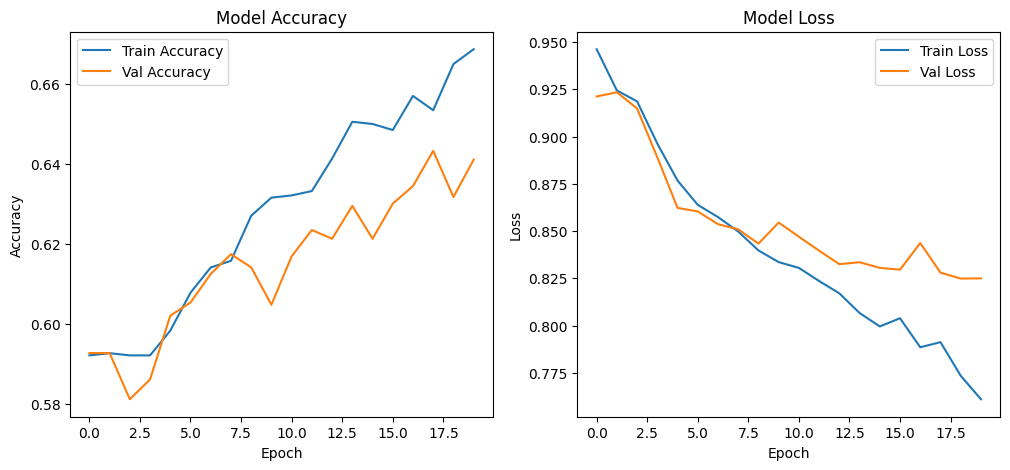

In [85]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [84]:
'''
from tensorflow.keras.models import load_model

model = load_model('best_lstm_model.keras')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data = (X_test, y_test),  # Using test set for validation
    callbacks=[checkpoint, early_stop]
)
'''


"\nfrom tensorflow.keras.models import load_model\n\nmodel = load_model('best_lstm_model.keras')\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer='adam',\n              metrics=['accuracy'])\n\nhistory = model.fit(\n    X_train,\n    y_train,\n    epochs=20,\n    batch_size=32,\n    validation_data = (X_test, y_test),  # Using test set for validation\n    callbacks=[checkpoint, early_stop]\n)\n"

In [88]:
def preprocess_single_tweet(tweet_text, tokenizer, max_length):
    cleaned_tweet = clean_text(tweet_text)
    sequence = tokenizer.texts_to_sequences([cleaned_tweet])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    return padded_sequence

#testing a tweet from cleaned tweets
categ = model.predict(preprocess_single_tweet(df['clean_text'][0], tokenizer, max_length))
predicted_probabilities = categ[0]

# Find the index of the highest probability (this is the numerical label 0, 1, 2, or 3)
predicted_label_encoded = np.argmax(predicted_probabilities)

# Map the numerical label back to the original category name using the stored LabelEncoder
predicted_category_name = label_encoder.inverse_transform([predicted_label_encoded])[0]

# Print the results
print(f"Tweet being tested: '{df['clean_text'][0]}'")
print(f"Original Label: '{df['is_there_an_emotion_directed_at_a_brand_or_product'].iloc[0]}'")
print(f"Encoded Label: {df['label'].iloc[0]}")
print(f"Predicted Probabilities: {predicted_probabilities}")
print(f"Predicted Encoded Label: {predicted_label_encoded}")
print(f"Predicted Category Name: {predicted_category_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tweet being tested: 'i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw'
Original Label: 'Negative emotion'
Encoded Label: 1
Predicted Probabilities: [0.02804357 0.09990094 0.44762835 0.42442712]
Predicted Encoded Label: 2
Predicted Category Name: No emotion toward brand or product
